In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def softmax(z):
    # Normalize input to prevent numerical instability
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def test_softmax():
    """
    Perform basic assertion tests on the softmax function to validate its correctness.
    Tests:
    - Ensure that the output probabilities sum to 1 for each row.
    - Ensure non-negative values (all probabilities should be >= 0).
    - Test on edge cases (e.g., all zeros, very large or small values).
    """
    # Test input
    test_cases = [(np.array([[0, 0, 0]]), "All zeros"),(np.array([[1, 2, 3]]), "Simple case"),(np.array([[1000, 1000, 1000]]), "Large identical values"),(np.array([[-1000, -1000, -1000]]), "Small identical values"),(np.array([[1, 0, -1]]), "Mixed positive and negative")]
    for i, (z, description) in enumerate(test_cases):
        print(f"Test {i + 1}: {description}")
        result = softmax(z)
        # Check that probabilities sum to 1
        assert np.allclose(result.sum(axis=1), 1), f"Failed: Probabilities do not sum to 1 in {description}"
        # Check non-negativity
        assert np.all(result >= 0), f"Failed: Negative probabilities in {description}"
        print("Passed.")
    print("All tests passed for softmax function.")
test_softmax()

Test 1: All zeros
Passed.
Test 2: Simple case
Passed.
Test 3: Large identical values
Passed.
Test 4: Small identical values
Passed.
Test 5: Mixed positive and negative
Passed.
All tests passed for softmax function.


In [5]:
def loss_softmax(y_true, y_pred):
    """
    Compute the cross-entropy loss for a single observation.
    Parameters:
    y_true (numpy.ndarray): True labels (one-hot encoded) of shape (c,).
    y_pred (numpy.ndarray): Predicted probabilities of shape (c,).
    Returns:
    float: Cross-entropy loss for the observation.
    """
    return -np.sum(y_true * np.log(y_pred + 1e-10)) # Add epsilon to prevent log(0)

In [6]:
def test_loss_softmax():
    """
    Test the loss_softmax function using a known input and output.
    """
    # Test Case 1: Perfect prediction
    y_true = np.array([0, 1, 0]) # True label (one-hot encoded)
    y_pred = np.array([0.1, 0.8, 0.1]) # Predicted probabilities
    expected_loss = -np.log(0.8) # Expected loss for perfect prediction
    assert np.isclose(loss_softmax(y_true, y_pred), expected_loss), "Test Case 1 Failed"
    # Test Case 2: Incorrect prediction
    y_true = np.array([1, 0, 0]) # True label (one-hot encoded)
    y_pred = np.array([0.3, 0.4, 0.3]) # Predicted probabilities
    expected_loss = -np.log(0.3) # Expected loss for incorrect prediction
    assert np.isclose(loss_softmax(y_true, y_pred), expected_loss), "Test Case 2 Failed"
    # Test Case 3: Edge case with near-zero probability
    y_true = np.array([0, 1, 0]) # True label (one-hot encoded)
    y_pred = np.array([0.01, 0.98, 0.01]) # Predicted probabilities
    expected_loss = -np.log(0.98) # Expected loss for edge case
    assert np.isclose(loss_softmax(y_true, y_pred), expected_loss), "Test Case 3 Failed"
    print("All test cases passed!")
# Run the test
test_loss_softmax()

All test cases passed!


In [7]:
def cost_softmax(X, y, W, b):
    """
    Compute the average cross-entropy cost over all samples.
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    Returns:
    float: Average cross-entropy cost over all samples.
    """
    n, d = X.shape
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    return -np.sum(y * np.log(y_pred + 1e-10)) / n

In [8]:
def test_cost_softmax():
    """
    Test the cost_softmax function using a known input and output.
    """
    # Test Case 1: Small dataset with perfect predictions
    X = np.array([[1, 2], [2, 3], [3, 4]]) # Feature matrix (n=3, d=2)
    y = np.array([[1, 0], [0, 1], [1, 0]]) # True labels (n=3, c=2, one-hot encoded)
    W = np.array([[1, -1], [-1, 1]]) # Weight matrix (d=2, c=2)
    b = np.array([0, 0]) # Bias vector (c=2)
    z = np.dot(X, W) + b
    y_pred = softmax(z) # Predicted probabilities
    expected_cost = -np.sum(y * np.log(y_pred + 1e-10)) / X.shape[0] # Compute expected cost
    assert np.isclose(cost_softmax(X, y, W, b), expected_cost), "Test Case 1 Failed"
    # Test Case 2: All-zero weights and bias
    X = np.array([[1, 0], [0, 1], [1, 1]]) # Feature matrix (n=3, d=2)
    y = np.array([[1, 0], [0, 1], [1, 0]]) # True labels (n=3, c=2, one-hot encoded)
    W = np.zeros((2, 2)) # Zero weight matrix
    b = np.zeros(2) # Zero bias vector
    z = np.dot(X, W) + b
    y_pred = softmax(z) # Predicted probabilities (uniform distribution)
    expected_cost = -np.sum(y * np.log(y_pred + 1e-10)) / X.shape[0] # Compute expected cost
    assert np.isclose(cost_softmax(X, y, W, b), expected_cost), "Test Case 2 Failed"
    print("All test cases passed!")
# Run the test
test_cost_softmax()

All test cases passed!


In [9]:
def compute_gradient_softmax(X, y, W, b):
    """
    Compute the gradients of the cost function with respect to weights and biases.
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    Returns:
    tuple: Gradients with respect to weights (d, c) and biases (c,).
    """
    n, d = X.shape
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    grad_W = np.dot(X.T, (y_pred - y)) / n
    grad_b = np.sum(y_pred - y, axis=0) / n
    return grad_W, grad_b

In [10]:
def test_compute_gradient_softmax():
    # Define simple inputs
    X = np.array([[1, 2], [3, 4]]) # Shape (2, 2)
    y = np.array([[1, 0], [0, 1]]) # Shape (2, 2), one-hot encoded
    W = np.array([[0.1, 0.2], [0.3, 0.4]]) # Shape (2, 2)
    b = np.array([0.01, 0.02]) # Shape (2,)
    # Expected gradients (calculated manually or using a reference implementation)
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    grad_W_expected = np.dot(X.T, (y_pred - y)) / X.shape[0]
    grad_b_expected = np.sum(y_pred - y, axis=0) / X.shape[0]
    # Compute gradients using the function
    grad_W, grad_b = compute_gradient_softmax(X, y, W, b)
    # Assertions
    assert np.allclose(grad_W, grad_W_expected, atol=1e-6), "Gradient W does not match expected values"
    assert np.allclose(grad_b, grad_b_expected, atol=1e-6), "Gradient b does not match expected values"
    print("All tests passed for compute_gradient_softmax!")
# Run the test
test_compute_gradient_softmax()

All tests passed for compute_gradient_softmax!


In [11]:
def gradient_descent_softmax(X, y, W, b, alpha, n_iter, show_cost=False):
    """
    Perform gradient descent to optimize the weights and biases.
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    alpha (float): Learning rate.
    n_iter (int): Number of iterations.
    show_cost (bool): Whether to display the cost at intervals.
    Returns:
    tuple: Optimized weights, biases, and cost history.
    """
    cost_history = []
    for i in range(n_iter):
        grad_W, grad_b = compute_gradient_softmax(X, y, W, b)
        W -= alpha * grad_W
        b -= alpha * grad_b
        cost = cost_softmax(X, y, W, b)
        cost_history.append(cost)
        if show_cost and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iteration {i}: Cost = {cost:.6f}")
    return W, b, cost_history

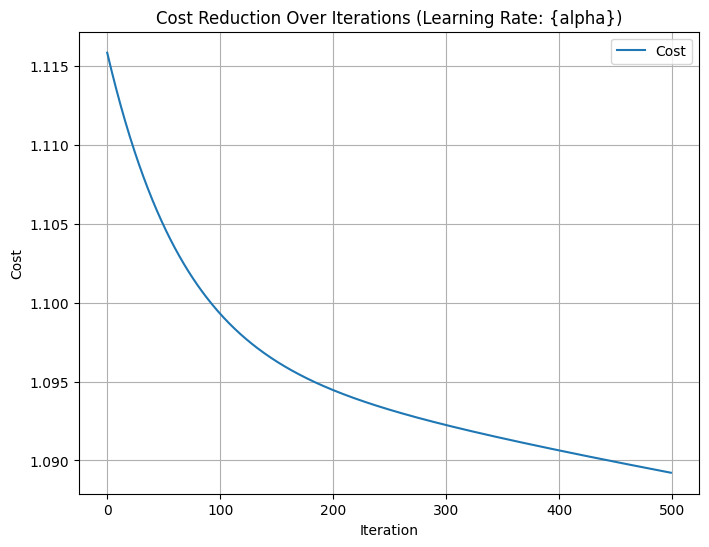

Initial Cost: 1.1158608479596404
Final Cost: 1.0892233754862581


In [12]:
import matplotlib.pyplot as plt
def test_gradient_descent_softmax_with_plot():
# Generate synthetic data for testing
    np.random.seed(0)
    n, d, c = 100, 5, 3 # 100 samples, 5 features, 3 classes
    X = np.random.rand(n, d)
    y_indices = np.random.randint(0, c, size=n)
    y = np.zeros((n, c))
    y[np.arange(n), y_indices] = 1
    W = np.random.rand(d, c)
    b = np.random.rand(c)
    # Parameters for gradient descent
    alpha = 0.01 # Learning rate
    n_iter = 500 # Number of iterations
    # Run gradient descent
    W_opt, b_opt, cost_history = gradient_descent_softmax(X, y, W, b, alpha, n_iter, show_cost=False)
    # Plot the cost history
    plt.figure(figsize=(8, 6))
    plt.plot(range(n_iter), cost_history, label="Cost")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Cost Reduction Over Iterations (Learning Rate: {alpha})")
    plt.legend()
    plt.grid()
    plt.show()
    # Final cost should ideally be less than initial cost
    print(f"Initial Cost: {cost_history[0]}")
    print(f"Final Cost: {cost_history[-1]}")
test_gradient_descent_softmax_with_plot()

In [13]:
def predict_softmax(X, W, b):
    """
    Predict the class labels for input data.
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    Returns:
    numpy.ndarray: Predicted class labels of shape (n,).
    """
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    return np.argmax(y_pred, axis=1)

In [14]:
def test_predict_softmax():
    # Generate synthetic data for testing
    np.random.seed(0)
    n, d, c = 10, 5, 3 # 10 samples, 5 features, 3 classes
    X = np.random.rand(n, d)
    W = np.random.rand(d, c)
    b = np.random.rand(c)
    # Compute the predictions using the function
    predictions = predict_softmax(X, W, b)
    # Check the shape of the output
    assert predictions.shape == (n,), f"Shape mismatch: expected {(n,)}, got {predictions.shape}"
    # Verify that all predicted labels are within the range of class indices
    assert np.all(predictions >= 0) and np.all(predictions < c), (f"Predictions out of range: expected 0 to {c-1}, got {predictions}")
    #Check that the predicted labels are integers
    assert np.issubdtype(predictions.dtype, np.integer), f"Predictions are not integers: {predictions.dtype}"
    print("All tests passed for predict_softmax!")
# Run the test
test_predict_softmax()

All tests passed for predict_softmax!


In [15]:
def evaluate_classification(y_true, y_pred):
  """
  Evaluate the classification performance using confusion matrix, precision, recall, and F1-score.
  Parameters:
  y_true (numpy.ndarray): True class labels of shape (n,).
  y_pred (numpy.ndarray): Predicted class labels of shape (n,).
  Returns:
  tuple: Confusion matrix, precision, recall, and F1-score.
  """
  from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
  cm = confusion_matrix(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
  recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
  f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
  return cm, precision, recall, f1

## Putting Helper Function to Action

In [16]:
def preprocess_titanic_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    df = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

    return df

Iteration 0: Cost = 3.819279
Iteration 100: Cost = 2.233052
Iteration 200: Cost = 1.493727
Iteration 300: Cost = 0.904085
Iteration 400: Cost = 1.425307
Iteration 500: Cost = 1.321268
Iteration 600: Cost = 1.003327
Iteration 700: Cost = 0.661015
Iteration 800: Cost = 0.901162
Iteration 900: Cost = 1.138481
Iteration 999: Cost = 1.382283


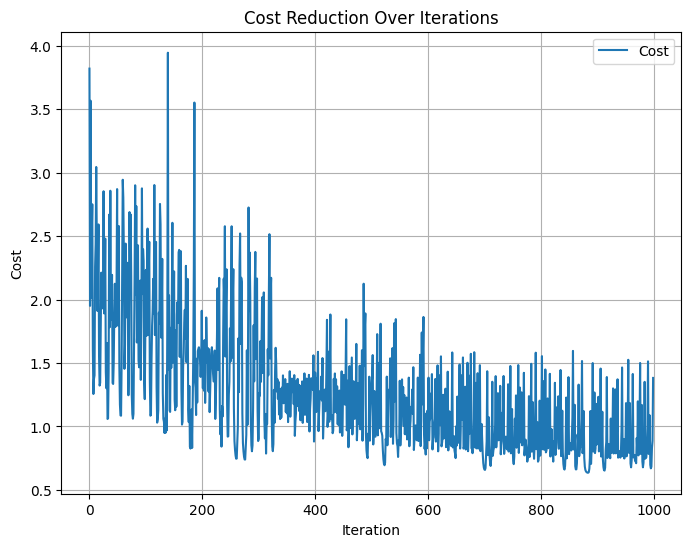

Confusion Matrix:
[[169.   0.  47.]
 [ 18.   0. 166.]
 [ 11.   0. 480.]]
Accuracy: 72.84%


In [19]:
def softmax_regression_titanic():
    # Load and preprocess data
    file_path = "/content/Titanic-Dataset.csv"
    df = preprocess_titanic_data(file_path)

    X = df.drop("Pclass", axis=1).values
    y = df["Pclass"].values

    y_one_hot = np.zeros((y.size, y.max()))
    y_one_hot[np.arange(y.size), y - 1] = 1

    n_samples, n_features = X.shape
    n_classes = y_one_hot.shape[1]
    W = np.random.rand(n_features, n_classes)
    b = np.random.rand(n_classes)

    alpha = 0.01
    n_iter = 1000

    W_opt, b_opt, cost_history = gradient_descent_softmax(X, y_one_hot, W, b, alpha, n_iter, show_cost=True)


    plt.figure(figsize=(8, 6))
    plt.plot(range(n_iter), cost_history, label="Cost")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Cost Reduction Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

    y_pred = predict_softmax(X, W_opt, b_opt)

    cm = np.zeros((n_classes, n_classes))
    for true_label, pred_label in zip(y - 1, y_pred):
        cm[true_label, pred_label] += 1

    print("Confusion Matrix:")
    print(cm)

    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Accuracy: {accuracy * 100:.2f}%")

softmax_regression_titanic()